


## PROCESS DESCRIPTION:

The report is structured into three sections. It begins with a brief overview, followed by the presentation of functions and codes. Finally, the report provides detailed results, charts, and additional information.

The report comprises two primary steps:

* Step 1: Data Cleaning and Creation of New Columns
* Step 2: Data Analysis and Visualization

Explanations related to Step 1:
The dataset contains a significant amount of missing data. For three columns with missing data exceeding 64%, the approach is to remove those columns. Hence, the following columns are deleted:

- "PREFERRED_RESTAURANT_TYPES" (87% missing data)
- "MEDIAN_DAYS_BETWEEN_PURCHASES" (64% missing data)
- "AVG_DAYS_BETWEEN_PURCHASES" (64% missing data)

Regarding the "PREFERRED_DEVICE" column, although it has some missing data (less than 1%), the decision is made to delete the corresponding rows.

For the remaining columns, various methods were initially considered and compared, such as replacing missing data with zero, using previous data in the respective column, or estimating missing data through regression or KNN. However, upon further examination, it was observed that the missing data are interconnected. Either the customer information is almost complete, or only the devices and registration dates are recorded. In the latter case, valuable data would be lost. Consequently, the decision is made to delete all such rows.

New Columns:
To evaluate the significance of delivery distance to customers, a new column named "DISTANCE_KMS_RANGE" is created to segment the delivery distances. This column aims to provide insights into the importance of delivery distance on customer behavior.

Additionally, three new columns are created to explore the relationship between orders and time. These columns are:

- "Day": Represents the day of the month
- "Week_Day": Represents the day of the week
- "week_number": Represents the week of the month

Explanations related to Step 2:
In this step, the analysis aims to answer the following questions:

* 2_1: How important is the delivery distance to customers?
* 2_2: Is there a relationship between ordering different meals throughout the day?
* 2_3: How many days after registration will Wolt receive the first order?
* 2_4: Is there a relationship between total sales (orders) and time?
* 2_5: Are Wolt's apps user-friendly enough?
* 2_6: Do Wolt's customers have the same taste in different countries?
* 2_7: How interested are Wolt's customers in food variety? Are they willing to take a risk and try a new restaurant, or do they tend to order food they have tried before?

In [338]:
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pylab as plt
from matplotlib.ticker import PercentFormatter
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression 
from sklearn.model_selection import train_test_split

**Global variables**

In [339]:
contry_list = ["FIN", "DNK", "GRC"]
colors2 = ["#8bd3c7", "#bd7ebe", "#ffb55a", "#ffee65", "#beb9db"]
colors = ["cyan", "royalblue", "#C71585", "darkblue", "lightcyan"]
col_list2 = ["BREAKFAST", "LUNCH", "EVENING", "DINNER", "MOST_COMMON_HOUR"]
col_list = ["BREAKFAST_PURCHASES", "LUNCH_PURCHASES", "EVENING_PURCHASES", "DINNER_PURCHASES"]

**Functions**

In [340]:
### This function checks the table and calculates the percentage of missing data for each column

def initial_review_table(df):
    isnull = df.isnull().sum()
    type_columns = df.dtypes
    pre = round((isnull/len(df))*100, 2)
    dc = pd.DataFrame({"Type":type_columns, 
                       "Isnull":isnull, 
                       "Missing data ٪":pre})
    print(dc.sort_values(by = "Missing data ٪", ascending = False))

In [341]:
### This function checks the "association rules" between 2 columns. 
### For instance, I am wondering to know if there is any relationship between ordering breakfast and lunch.

def association_rules(df, col1, col2):
    count_col1 = df[col1][df[col1] > 0].count()
    count_col2 = df[col2][df[col2] > 0].count()
    count_col1_col2 = df[col1][(df[col1] > 0) & (df[col2] > 0) ].count()
    
    pro_col1 = count_col1/len(df)
    pro_col2 = count_col2/len(df)
    support = count_col1_col2/len(df)
    confidence = support/pro_col1
    lift = confidence/pro_col2
    return (round(support*100,1).astype(str) + "%"), (round(confidence*100,1).astype(str) + "%"), lift

def association_table():
    ind, support, confidence, lift=[], [], [], []
    for i in range (4):
        for j in range (4):
            if i != j:
                ind1 = ""
                asso, conf, lif = association_rules(df, col_list[i], col_list[j])
                ind1 = col_list2[i] + " & " + col_list2[j]
                support.append(asso)
                confidence.append(conf)
                lift.append(lif)
                ind.append(ind1)
    association_table = pd.DataFrame({"2 different meals relationship": ind, "Support": support, "Confidence": confidence, "Lift": lift})
    return association_table

In [342]:
### This function counts the number of days between the registration date and the first order date.

def first_order(df):
    registr_date = pd.to_datetime(df["REGISTRATION_DATE"])
    order_date = pd.to_datetime(df["FIRST_PURCHASE_DAY"])
    wating_day = order_date - registr_date
    total = len(wating_day)
    wating_table = pd.DataFrame({"Wating_day": wating_day, "count": 1})
    count_wating_day = wating_table.groupby(["Wating_day"]).count().sort_values("count", ascending = False)
    count_wating_day.reset_index(drop = True, inplace = True)
    count_wating_day["Percentage %"] = (count_wating_day["count"]/total)*100
    return count_wating_day

def first_order_plot():
    first_or = first_order(df)
    plt.plot(first_or["Percentage %"], "-", color = "#C71585")
    plt.ylabel("First order", size = 12, c = "black")
    plt.xlabel("Days", size = 12, c = "black")
    plt.title("Waiting time for the first order after registration", size = 12, color = "black")
    plt.show()

In [343]:
### This function calculates the sum of certain meals.
def total_meals(df, col):
    sum_group = df.groupby(["REGISTRATION_COUNTRY"]).sum(numeric_only = True)
    sum_col = sum_group[col].sort_values(ascending = False).head(3)
    return sum_col

In [344]:
### This function calculates the sum of specific columns for a specific country.

def country_(item):
    df_country = df[df["REGISTRATION_COUNTRY"].isin([item])]
    df_country_2 = df_country[col_list].sum()
    return df_country_2    

In [345]:
# 1- This function separates distinct purchases into 5 different groups. 
#2- It calculates the number of customers belonging to each group
#3- Creates a table to display the data

def distinctive_purchase(df):
    
    def count_distinctive_purchase(df):
        dic = {}
        purchase = []
        pur = df["USER_ID"][(df["DISTINCT_PURCHASE_VENUE_COUNT"] < 2)].count()*100
        purchase.append(pur)
        pur = df["USER_ID"][(df["DISTINCT_PURCHASE_VENUE_COUNT"] >= 2) & (df["DISTINCT_PURCHASE_VENUE_COUNT"] < 4)].count()*100
        purchase.append(pur)
        pur = df["USER_ID"][(df["DISTINCT_PURCHASE_VENUE_COUNT"] >= 4) & (df["DISTINCT_PURCHASE_VENUE_COUNT"] < 7)].count()*100
        purchase.append(pur)
        pur = df["USER_ID"][(df["DISTINCT_PURCHASE_VENUE_COUNT"] >= 7) & (df["DISTINCT_PURCHASE_VENUE_COUNT"] < 10)].count()*100
        purchase.append(pur)
        pur = df["USER_ID"][(df["DISTINCT_PURCHASE_VENUE_COUNT"] >= 10)].count()*100
        purchase.append(pur)
        for i in range(5):
            dis_purchase = purchase[i]/len(df)
            dic[i] = "{:.2f}".format(dis_purchase) + "%"
        return dic
    list_3 = ["place = 1", "1 < places <= 4", "4 < places <= 7", "7 < places <= 10", "10 < places"]    
    dic = count_distinctive_purchase(df)
    ds = pd.DataFrame.from_dict(dic, orient="index")
    ds.rename(columns = {0: "Customer Behavior(Rate)"}, inplace = True)
    ds.insert(0, "Number of Places(Range)", list_3)
    ds = ds.style.hide(axis = "index")
    return ds

In [346]:
#This function draws 3 graphs. 
#Total daily orders
#Total monthly orders by day of the week
#Weekly order by day of the week.


def  total_order_amount_chart():
    plt.figure(1)
    
    sales = df.groupby(["Day"]).sum(numeric_only = True)
    
    plt.bar(sales.index, sales["TOTAL_PURCHASES_EUR"], color = "#6C7B8B", label = "Total Order")
    plt.ylabel("Total order(¢)", size = 12, c = "black")
    plt.xlabel("September 2019 days", size = 12, c = "black")
    plt.title("Total daily order in September 2019", size = 12, color = "black")
    plt.legend ()
    
    plt.figure(2)
    
    week = df.groupby(["Week_Day"]).sum(numeric_only = True)
    
    plt.bar(week.index, week["TOTAL_PURCHASES_EUR"], color = "#8B668B", label = "Total Order")
    plt.ylabel("Total sales(¢)", size = 12, c = "black")
    plt.xlabel("Days of the week / September 2019", size = 12, c = "black")
    plt.title("Total order in September based on days of the week", size = 12, color = "black")
    plt.legend ()
    
    plt.figure(3)
    
    df_pivot = pd.pivot_table(df, 
                              values = "TOTAL_PURCHASES_EUR", 
                              index = "week_number",
                              columns = "Week_Day"
                             )
    
    ax = df_pivot.plot.bar()
    plt.ylabel("Total weekly order(¢)", size = 12, c = "black")
    plt.xlabel("Weeks of September 2019", size = 12, c = "black")
    plt.title("Total weekly order in September 2019", size = 12, color = "black")
    ax.legend("")
    plt.show()

In [347]:
# This function plots a regression line for total monthly orders by day of the week.
def regression_line():
    week = df.groupby(["Week_Day"]).sum(numeric_only = True)
    model = LinearRegression () 
    x = week.index.to_frame ()
    y = week["TOTAL_PURCHASES_EUR"] 
    model.fit(x , y)
    mod1_coef = model.coef_
    mod1_intercept = model.intercept_
    plt.scatter(x , y)
    formula = mod1_coef*x + mod1_intercept
    fig = plt.plot(x, formula, c = "red", label = "Regression Line", alpha = 0.3)
    sns.set()
    plt.title("Regression Line", size = 14, color = "g")
    plt.show()

In [348]:
# This function calculates the delivery distance and plots a pie chart.
def delivery_distance():
    delivery_distance = df.groupby("DISTANCE_KMS_RANGE").count()
    labels = delivery_distance.index
    plt.figure(figsize = (4,4))
    plt.pie(delivery_distance["USER_ID"].values, autopct = "%1.1f%%", startangle = 140, shadow = True, labels = labels)
    plt.title("Customer preference in ordering based on distance", size = 14, color = "g")
    plt.show()
    

In [349]:
#This function compares the number of different devices by drawing a pie chart.
def devices_type():    
    device = df.groupby("PREFERRED_DEVICE").count()
    colors = ["cyan", "royalblue", "#C71585"]
    labels = device.index
    explode = [0.05, 0.05, 0.05]
    plt.figure(figsize = (4,4))
    plt.pie(device["USER_ID"].values, autopct = "%1.1f%%", startangle = 140, explode = explode, shadow = True, colors = colors, labels = labels)
    centre_circle = plt.Circle((0,0),0.4,fc="white")
    fig = plt.gcf()
    fig.gca().add_artist(centre_circle)
    plt.title("Type of customer's devices", size = 12, color = "g")
    plt.show()

In [350]:
# This function performs customer segmentation based on registered country.
def customer_segmentation():
    df_coun = df[["REGISTRATION_COUNTRY", "USER_ID"]].groupby("REGISTRATION_COUNTRY").count().sort_values("USER_ID", ascending=False).head(4)
    labels = [df_coun.index[0], df_coun.index[1], df_coun.index[2], "Other Countries"]
    plt.figure(figsize = (4,4))
    plt.pie(df_coun["USER_ID"].values, autopct = "%1.1f%%", startangle = 140, shadow = True, labels = labels)
    title = "Customer Segmentation"
    plt.title(title, size = 12, color = "g")
    plt.show()


In [351]:
# This function plots the amount of total meals in 4 groups.
def customer_taste():
    fig = plt.figure(figsize=(12, 10), dpi=130)
    
    ax1 = plt.subplot2grid((1, 4), (0, 0))
    sum_col = total_meals(df, col_list[0])
    plt.pie(sum_col.values, autopct = "%1.1f%%", startangle = 140, shadow = True, colors = colors, labels = sum_col.index, textprops = {"fontsize": 8})
    plt.title(col_list[0], size=8, color = "g")
    #next one
    ax1 = plt.subplot2grid((1, 4), (0, 1))
    sum_col = total_meals(df, col_list[1])
    plt.pie(sum_col.values, autopct = "%1.1f%%", startangle = 140, shadow = True, colors = colors, labels = sum_col.index, textprops = {"fontsize": 8})
    plt.title(col_list[1], size=8, color = "g")
    #next one
    ax1 = plt.subplot2grid((1, 4), (0, 2))
    sum_col = total_meals(df, col_list[2])
    plt.pie(sum_col.values, autopct = "%1.1f%%", startangle = 140, shadow = True, colors = colors, labels = sum_col.index, textprops = {"fontsize": 8})
    plt.title(col_list[2], size=8, color = "g")
    #next one
    ax1 = plt.subplot2grid((1, 4), (0, 3))
    sum_col = total_meals(df, col_list[3])
    plt.pie(sum_col.values, autopct = "%1.1f%%", startangle = 140, shadow = True, colors = colors, labels = sum_col.index, textprops = {"fontsize": 8})
    plt.title(col_list[3], size=8, color = "g")
    
    plt.show()


In [352]:
#This function plots the amount of total meals for 3 countries.
def customer_taste_2():  
    fig = plt.figure(figsize=(12,8), dpi=200)
    
    ax1 = plt.subplot2grid((2, 2),(0,0))
    cont = country_(contry_list[0])
    plt.pie(cont.values, autopct = "%1.1f%%", startangle = 140, shadow = True, colors = colors2, labels = cont.index, textprops={"fontsize": 8})
    plt.title(contry_list[0], size=13, color = "g")
    
    #next one
    ax1 = plt.subplot2grid((2, 2), (0, 1))
    cont = country_(contry_list[1])
    plt.pie(cont.values, autopct = "%1.1f%%", startangle = 140, shadow = True, colors = colors2, labels = cont.index, textprops={"fontsize": 8})
    plt.title(contry_list[1], size=13, color = "g")
    
    #next one
    ax1 = plt.subplot2grid((2, 2),(1,0))
    cont = country_(contry_list[2])
    plt.pie(cont.values, autopct = "%1.1f%%", startangle = 140, shadow = True, colors = colors2, labels = cont.index, textprops={"fontsize": 8})
    plt.title(contry_list[2], size=13, color = "g")
    
    plt.show()

In [353]:

def distinctive_plot(col):  

    dss1 = df[df["DISTINCT_PURCHASE_VENUE_COUNT"] < 60]
    dss2 = dss1[dss1["REGISTRATION_COUNTRY"].isin([col])]
    dss3 = dss2.groupby("DISTINCT_PURCHASE_VENUE_COUNT").count()
    dss3["cumpercentage"] = dss3["USER_ID"].cumsum()/dss3["USER_ID"].sum()*100
    
    fig, ax = plt.subplots()
    ax.scatter(dss3.index, dss3["USER_ID"], s = 20, alpha = 0.8, marker = "x", color = "#0000FF")
    ax2 = ax.twinx()
    ax2.plot(dss3.index, dss3["cumpercentage"], color =  "#DB7093", marker = "D", ms = 2)
    ax2.yaxis.set_major_formatter(PercentFormatter())
    title = "Interest in Diversity << " + col +" >>"
    ax.tick_params(axis = "y", colors = "#050505")
    ax2.tick_params(axis = "y", colors = "#050505")
    plt.title(title, size=12, color = "g")
    plt.show()

In [354]:
# This function plots distinct putchase for 3 countries("DNK", "FIN", "GRC")

def count_distinct(df):
    df_fin_dnk_grc = df[df["REGISTRATION_COUNTRY"].isin(["DNK", "FIN", "GRC"])]
    df_fin_dnk_grc = df_fin_dnk_grc[df_fin_dnk_grc["DISTINCT_PURCHASE_VENUE_COUNT"] > 10]
    count_customers = df_fin_dnk_grc.groupby("REGISTRATION_COUNTRY").count()
    plt.figure(figsize = (4,4))
    plt.pie(count_customers["USER_ID"].values, autopct = "%1.1f%%", startangle = 140, shadow = True, labels = count_customers.index)
    title = "Customer behavior where distinct purchase is > 10"
    plt.title(title, size=12, color = "g")
    plt.show()

In [355]:
#This function plots distinct putchase for 3 countries("DNK", "FIN", "GRC") where it is 1.
def distinct_one(df):
    df_fin_dnk_grc = df[df["REGISTRATION_COUNTRY"].isin(["DNK", "FIN", "GRC"])]
    df_fin_dnk_grc = df_fin_dnk_grc[df_fin_dnk_grc["DISTINCT_PURCHASE_VENUE_COUNT"] == 1]
    count_customers = df_fin_dnk_grc.groupby("REGISTRATION_COUNTRY").count()
    plt.figure(figsize = (4,4))
    plt.pie(count_customers["USER_ID"].values, autopct = "%1.1f%%", startangle = 140, shadow = True, labels = count_customers.index)
    title = "Customer behavior where distinct purchase is one"
    plt.title(title, size=12, color = "g")
    plt.show()


### Step_1_1: Data cleaning and deal with missing data 


In [356]:
df = pd.read_csv("dataset_for_analyst_assignment_20201120.csv")
df.head(4)

,REGISTRATION_DATE,REGISTRATION_COUNTRY,PURCHASE_COUNT,PURCHASE_COUNT_DELIVERY,PURCHASE_COUNT_TAKEAWAY,FIRST_PURCHASE_DAY,LAST_PURCHASE_DAY,USER_ID,BREAKFAST_PURCHASES,LUNCH_PURCHASES,...,WEB_PURCHASES,ANDROID_PURCHASES,PREFERRED_RESTAURANT_TYPES,USER_HAS_VALID_PAYMENT_METHOD,MOST_COMMON_HOUR_OF_THE_DAY_TO_PURCHASE,MOST_COMMON_WEEKDAY_TO_PURCHASE,AVG_DAYS_BETWEEN_PURCHASES,MEDIAN_DAYS_BETWEEN_PURCHASES,AVERAGE_DELIVERY_DISTANCE_KMS,PURCHASE_COUNT_BY_STORE_TYPE
0,2019-09-01 00:00:00.000,DNK,0,NaN,NaN,NaN,NaN,1,NaN,NaN,...,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,"{\n ""General merchandise"": 0,\n ""Grocery"": 0..."
1,2019-09-01 00:00:00.000,FIN,1,1.0,0.0,2020-09-02 00:00:00.000,2020-09-02 00:00:00.000,2,0.0,1.0,...,0.0,1.0,NaN,False,23.0,2.0,NaN,NaN,6.853,"{\n ""General merchandise"": 0,\n ""Grocery"": 0..."
2,2019-09-01 00:00:00.000,DNK,19,19.0,0.0,2019-12-10 00:00:00.000,2020-05-25 00:00:00.000,3,0.0,4.0,...,19.0,0.0,NaN,True,21.0,2.0,9.0,3.0,6.559,"{\n ""General merchandise"": 1,\n ""Grocery"": 9..."
3,2019-09-01 00:00:00.000,FIN,0,NaN,NaN,NaN,NaN,4,NaN,NaN,...,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,"{\n ""General merchandise"": 0,\n ""Grocery"": 0..."


In [357]:
initial_review_table(df)

                                            Type  Isnull  Missing data ٪
PREFERRED_RESTAURANT_TYPES                object   19289           87.75
MEDIAN_DAYS_BETWEEN_PURCHASES            float64   14151           64.37
AVG_DAYS_BETWEEN_PURCHASES               float64   14151           64.37
FIRST_PURCHASE_DAY                        object   10019           45.58
LAST_PURCHASE_DAY                         object    9956           45.29
MIN_PURCHASE_VALUE_EUR                   float64    9955           45.28
TOTAL_PURCHASES_EUR                      float64    9955           45.28
ANDROID_PURCHASES                        float64    9955           45.28
WEB_PURCHASES                            float64    9955           45.28
IOS_PURCHASES                            float64    9955           45.28
AVG_PURCHASE_VALUE_EUR                   float64    9955           45.28
MAX_PURCHASE_VALUE_EUR                   float64    9955           45.28
DISTINCT_PURCHASE_VENUE_COUNT            float64   

In [358]:
df.drop(["PREFERRED_RESTAURANT_TYPES","MEDIAN_DAYS_BETWEEN_PURCHASES","AVG_DAYS_BETWEEN_PURCHASES"],axis=1,inplace=True)
df.dropna(inplace=True)


### Step_1_2: Creating new columns to extract more information



In [359]:
df["DISTANCE_KMS_RANGE"] = df["AVERAGE_DELIVERY_DISTANCE_KMS"].apply(lambda x: "Less than 3 km" if (x < 3) else
                                                                    ("Between 3-6 km" if (x < 6) else
                                                                    ("Between 6-9 km" if (x < 9) else 
                                                                    "More than 9 km")))

In [360]:
df["Day"] = df["REGISTRATION_DATE"].str.slice(8, 10).astype(int)
df["Week_Day"] = pd.to_datetime(df["REGISTRATION_DATE"], format="%Y-%m-%d %H:%M:%S")
df["Week_Day"] = df["Week_Day"].dt.dayofweek + 1

In [361]:
df["week_number"] = df["Day"].apply(lambda x: 1 if (x < 8) else
                                                       (2 if (x < 15) else
                                                       (3 if (x < 22) else
                                                       (4 if (x < 29) else 5))))



### Step_2_1: How important the delivery distance is to the customers?

The study aimed to examine the significance of delivery distance on customer behavior. By categorizing the delivery distance into four distinct groups, interesting insights were obtained. Surprisingly, an almost equal percentage of orders were observed across all groups. This indicates that the delivery distance does not significantly affect the number of orders placed by customers.

The findings highlight the influential role of customer preference in their decision-making process, suggesting that their liking for a particular product or service surpasses concerns related to delivery distance. It implies that customers are willing to wait for something they truly enjoy, regardless of how far it needs to be delivered. This emphasizes the importance of understanding and catering to customer preferences to ensure a satisfying experience, as it can override any potential impact of delivery distance.




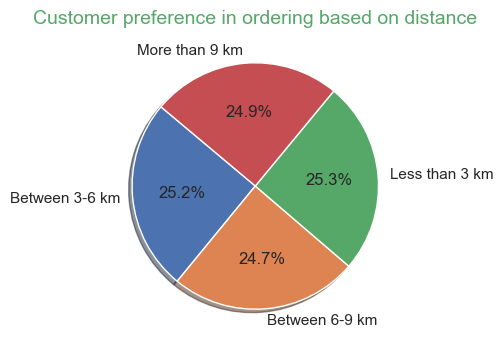

In [362]:
delivery_distance()

### Step_2_2: Is there a relationship between ordering different meals throughout the day?


To investigate this, three **"Association Rules"** were examined. However, the results revealed that there is no significant relationship or dependency between different meals during the day. Each meal choice appeared to be an independent variable, suggesting that customers make their ordering decisions based on their individual preferences and needs, rather than following a consistent pattern throughout the day.

In [363]:
association_table()

,2 different meals relationship,Support,Confidence,Lift
0,BREAKFAST & LUNCH,7.9%,79.8%,1.307452
1,BREAKFAST & EVENING,3.6%,35.8%,1.663527
2,BREAKFAST & DINNER,7.0%,70.2%,0.945145
3,LUNCH & BREAKFAST,7.9%,13.0%,1.307452
4,LUNCH & EVENING,14.1%,23.1%,1.072552
5,LUNCH & DINNER,40.7%,66.7%,0.897543
6,EVENING & BREAKFAST,3.6%,16.5%,1.663527
7,EVENING & LUNCH,14.1%,65.5%,1.072552
8,EVENING & DINNER,15.9%,73.8%,0.992673
9,DINNER & BREAKFAST,7.0%,9.4%,0.945145


### Step_2_3: How many days after registration will Wolt receive the first order?

It is interesting to note that nearly 50% of customers place their first order on the same day as their registration. However, the number of first-time orders diminishes rapidly thereafter, following a pattern similar to that of an exponential decay function. On the second day, only 4% of customers place their first order, and this further reduces to less than 2% on the third day.

Given this trend, the third day presents an opportune moment for the marketing team to take proactive measures and engage customers to encourage them to place an order. At this stage, customers may still be receptive to promotional offers or incentives that can entice them to make a purchase. By capitalizing on this window of opportunity, the marketing team can effectively leverage customer behavior and stimulate order activity.


In [364]:
first_order(df).head(8)

,count,Percentage %
0,5834,48.767032
1,414,3.460670
2,188,1.571512
3,118,0.986375
4,83,0.693806
5,80,0.668729
6,78,0.652010
7,69,0.576778


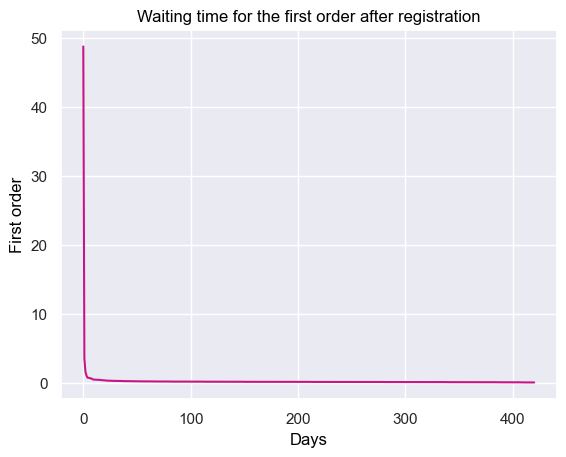

In [365]:
first_order_plot()

### Step_2_4: Is there a relationship between total sales (orders) and time?

The graph illustrates the total orders during the month of September, categorized by the days of the week. Interestingly, the lowest number of orders is observed on the second day of the week, while the order volume gradually increases as we approach the weekend. This observation indicates a linear relationship between the day of the week and the total number of orders. As the week progresses towards the weekend, there is a noticeable upward trend in the order count, suggesting a correlation between these two variables.

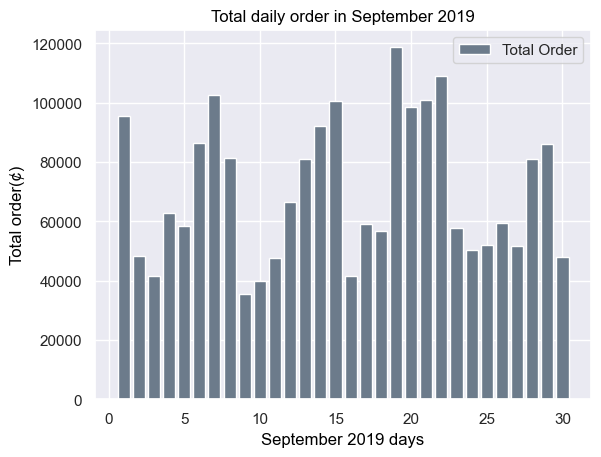

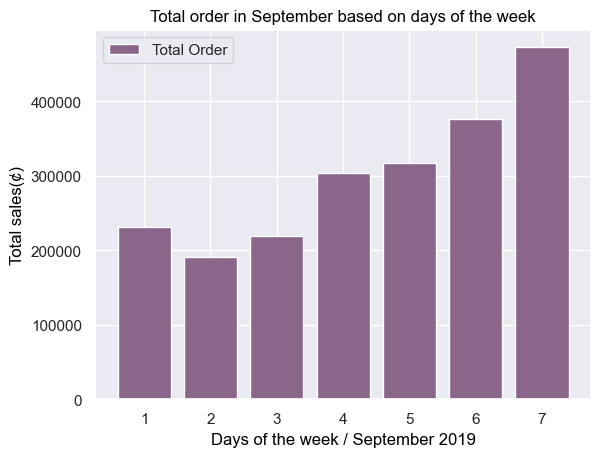

<Figure size 640x480 with 0 Axes>

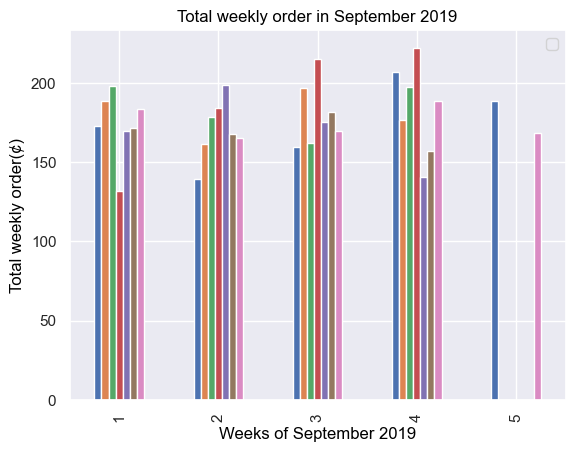

In [366]:
total_order_amount_chart()

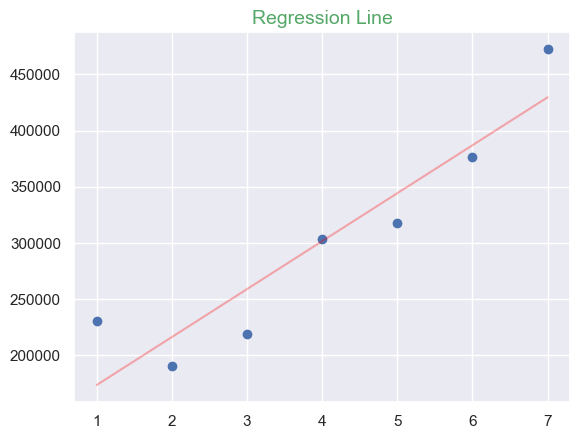

In [367]:
regression_line()

### Step_2_5: Are Wolt's apps user-friendly enough?

While it is expected that most orders come from ISO and Android devices, it is still important to assess the user-friendliness of the website design. Monitoring the trend of device usage can provide valuable insights. If there is a significant deviation between Wolt's customer base and the overall trends, it could indicate underlying reasons. For instance, if the usage trend for Windows devices is 5%, but 20% of Wolt's customers use Windows, it may suggest a potential issue with the Android or iOS versions of the platform. Therefore, evaluating and addressing any discrepancies can help improve the overall user experience and identify potential areas for improvement.

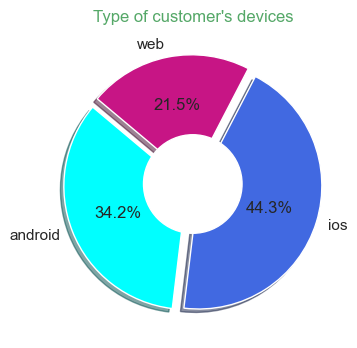

In [368]:
devices_type()

### Step_2_6: Do Wolt's customers have the same taste in different countries?

The majority of Wolt's customer base is concentrated in three countries: Finland, Denmark, and Greece. Customers from other countries account for less than 1% of the total. Therefore, the analysis focuses specifically on these three countries. The findings reveal interesting patterns, including:

* 50% of breakfast orders originate from Greece.
* 50% of dinner orders are placed by customers from Denmark.
* In Denmark, there is a preference for dinner and lunch orders.
* In Greece, customers show a preference for breakfast and dinner orders.
* In Finland, breakfast and lunch orders are more popular compared to dinner.

These insights highlight country-specific preferences in terms of meal choices, shedding light on the varying consumption habits among Wolt's customers in these three countries.


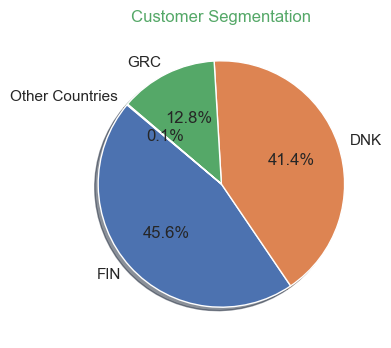

In [369]:
customer_segmentation()

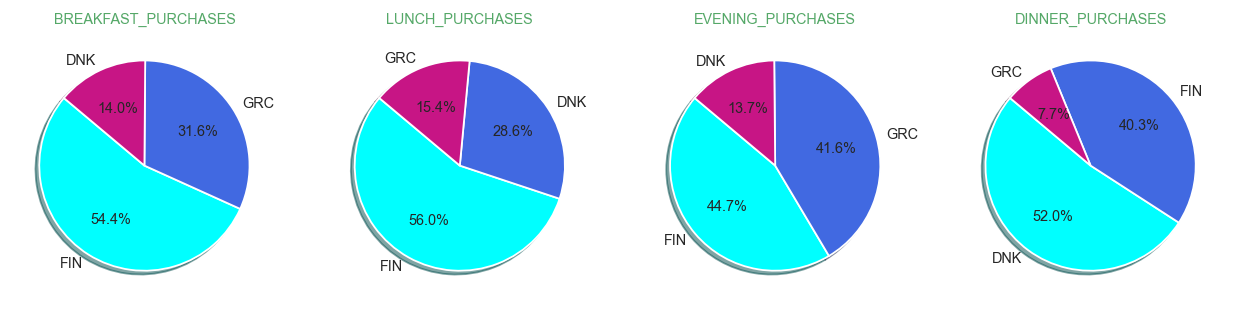

In [370]:
customer_taste()

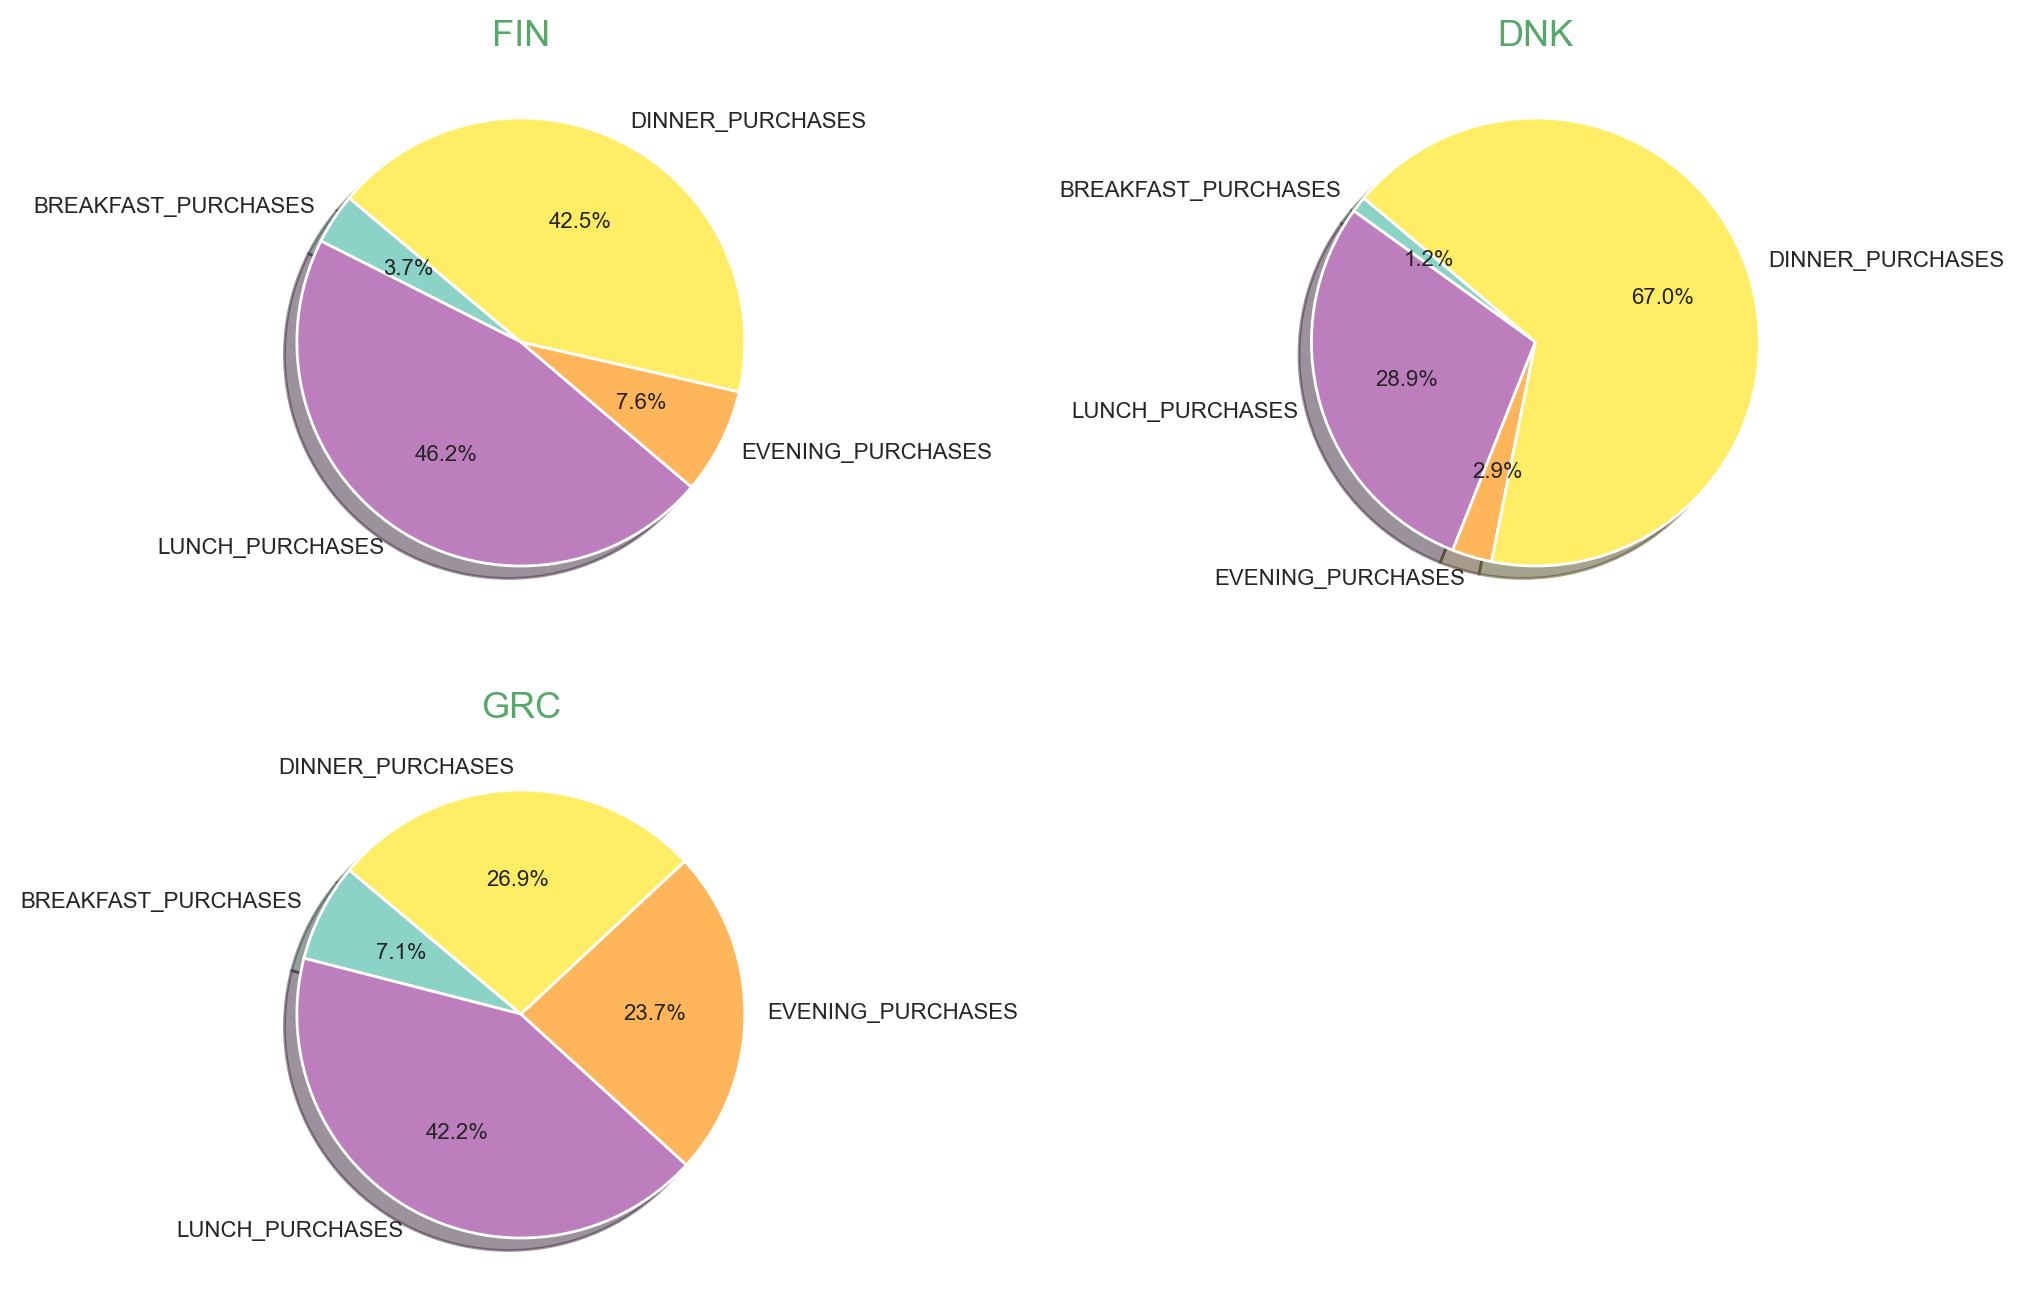

In [371]:
customer_taste_2()

### Step_2_7: How interested are Wolt's customers in food variety? 

Based on the analysis, the findings regarding customers' willingness to try new restaurants or order familiar dishes are as follows:

* Approximately **40%** of customers show a strong preference for a particular restaurant and are not inclined to explore different options.
* The majority, accounting for **60%** of customers, limit their orders to a maximum of two places, indicating a preference for a small selection of familiar choices.
* Around **6%** of customers display a high level of interest in trying diverse foods, with a significant portion of this group originating from Denmark.
* While the interest in diverse food options is slightly higher in Greece compared to Finland and Denmark, it remains relatively low overall.
* Overall, it appears that most customers exhibit a risk-averse behavior, particularly when it comes to trying new dishes and restaurants.

These findings suggest that customers tend to prioritize familiarity and stick to what they know when it comes to ordering food, indicating a preference for reliability and established choices rather than taking risks with unfamiliar options.



In [372]:
distinctive_purchase(df)

Number of Places(Range),Customer Behavior(Rate)
place = 1,40.68%
1 < places <= 4,29.47%
4 < places <= 7,17.24%
7 < places <= 10,6.47%
10 < places,6.14%


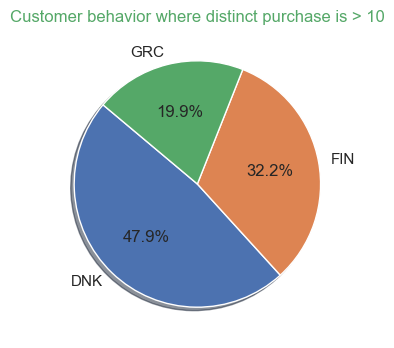

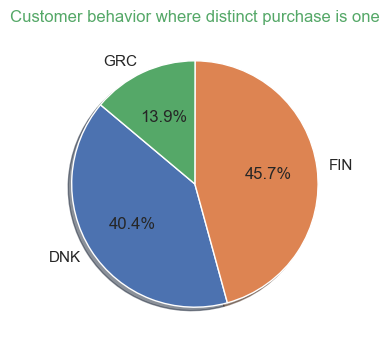

(None, None)

In [373]:
count_distinct(df), distinct_one(df)

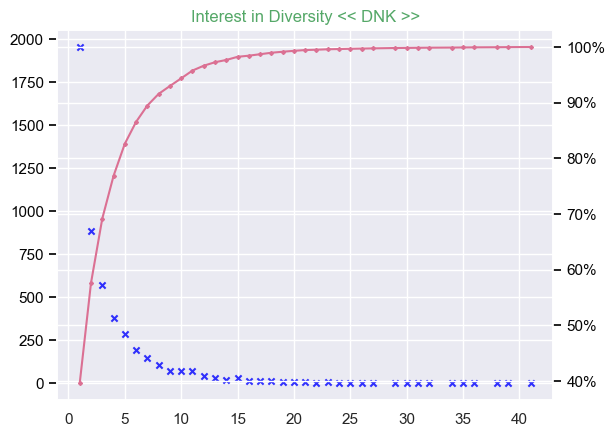

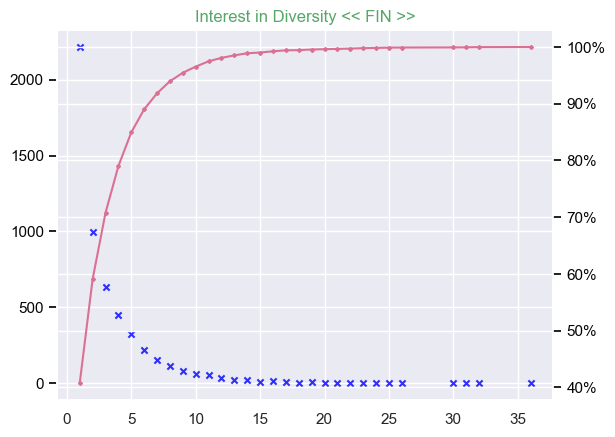

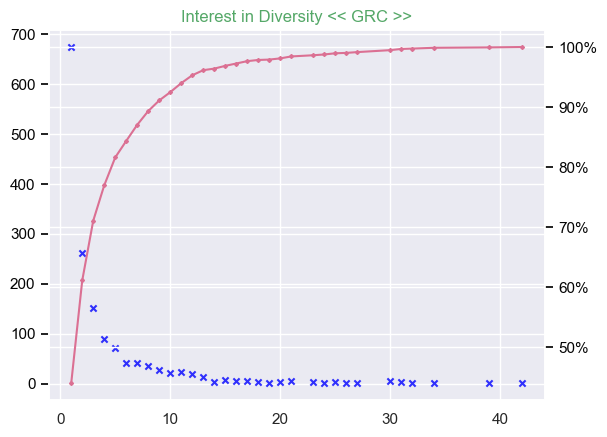

In [374]:
col = ["DNK", "FIN", "GRC"]
for country in col:
    distinctive_plot(country)